In [1]:
import os
import sys
sys.path.append('../python')

import pandas as pd
import numpy as np
import yaml
import time
import json
import ast
import pickle
import xgboost as xgb

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, root_mean_squared_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin

from matplotlib import pyplot as plt
from matplotlib import cm 

import api
import data_tools
import text_tools

rng = np.random.default_rng(20241025)

sheet = 1
namespace = f'la_planning_dept_cases_{sheet}'
embeddings_filename = f"temp-embeddings-{namespace}-2025-02-07.pkl"
use_file = True  # Whether to try to load embeddings from file

CENSOR_DATE = pd.to_datetime('2022-08-01')

/Users/ekung/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/ekung/Library/Python/3.9/lib/python/site-packages/pinecone/data/index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
# Load the data
df = data_tools.get_la_planning_dept_cases(sheet=sheet)
df = df.loc[ df['case_pfx']!=''].reset_index(drop=True)
len(df)

6584

In [3]:
df['Completion Date'].describe()

count                             6584
mean     2019-04-22 23:42:17.059538176
min                2015-01-02 00:00:00
25%                2017-09-27 00:00:00
50%                2019-07-01 00:00:00
75%                2021-02-09 00:00:00
max                2022-06-30 00:00:00
Name: Completion Date, dtype: object

In [4]:
df[['Case Number', 'Total Adding', 'Total Demo', 'Council District', 'Filed Date', 'Completion Date',
   'Project Description', 'Requested Entitlement']].sample(5)

,Case Number,Total Adding,Total Demo,Council District,Filed Date,Completion Date,Project Description,Requested Entitlement
6219,ADM-2022-170-RDP,2,0,10,2022-01-11,2022-01-11,CONVERT (E) 4 COVERED PKG STALLS TO 2 NEW ADUS...,0
2761,DIR-2018-3411-TOC,17,4,11,2018-06-13,2018-12-19,"PURSUANT TO: 12.22.A.31, A TIER 3 TOC PROJECT ...","CONSTRUCTION, USE, AND MAINTENANCE OF 17 UNIT ..."
1189,DIR-2016-3625-CDP-MEL,1,1,11,2016-09-22,2017-02-09,"PURSUANT TO LAMC 12.20.2, A COASTAL DEVELOPMEN...",COASTAL DEVELOPMENT PERMIT
1386,DIR-2016-3934-CLQ-DB,33,2,3,2016-10-17,2017-06-08,ZONE CHANGE TO REVISE THE T AND Q CONDITIONS I...,DEMOLITION OF AN EXISTING SINGLE-FAMILY DWELLI...
5722,ADM-2021-8407-RDP,2,0,8,2021-10-05,2021-10-05,CONVERT EXISTING RECREATION ROOMS AT LEVEL 1 O...,0


In [5]:


base_column_transformer_steps = [
    ('base_physical', StandardScaler(), [
        'Affordable Adding','Market Adding','Affordable Demo','Market Demo',
        'Guest Adding','Guest Demo','NonRes Adding','NonRes Demo'
    ]),
    ('base_categorical', OneHotEncoder(), ['Council District'])
]
pfx_column_transformer_steps = [
    ('pfx', OneHotEncoder(), ['case_pfx'])
]


In [6]:
# Load embeddings from file if file exists, otherwise retrieve embeddings from Pinecone/OpenAI
texts = list(df['text'])
if use_file and os.path.exists(embeddings_filename):
    with open(embeddings_filename, 'rb') as f:
        embeddings = pickle.load(f)
else:
    %time embeddings = api.get_embeddings(texts, namespace=namespace)
    with open(embeddings_filename, 'wb') as f:
        pickle.dump(embeddings, f) 
embeddings = np.array(embeddings)

Records retrieved from Pinecone: 6584
Records processed by OpenAI: 0
Pinecone Read Units: 669
CPU times: user 13.5 s, sys: 676 ms, total: 14.1 s
Wall time: 1min


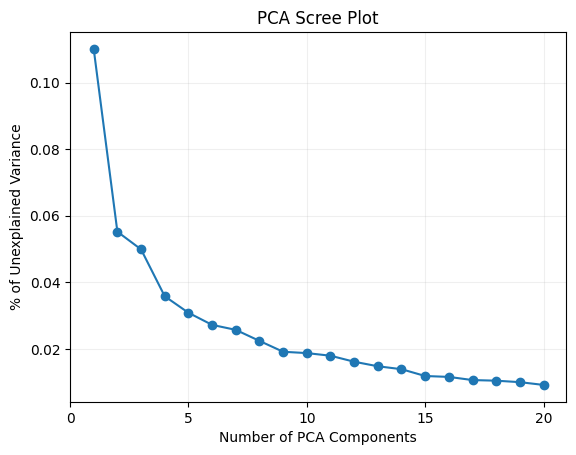

In [7]:
# Scree plot to show first 20 principal components
K = 20
pca = PCA(n_components=K)
pca.fit(embeddings)
plt.plot(np.arange(pca.n_components_)+1, pca.explained_variance_ratio_, 'o-')
plt.xticks(range(0,21,5))
plt.grid(alpha=0.2)
plt.xlabel('Number of PCA Components')
plt.ylabel('% of Unexplained Variance')
plt.title('PCA Scree Plot')
plt.show()

In [8]:
# Do the PCA with a smaller number of components
K = 10
pca = PCA(n_components=K)
X = pca.fit_transform(embeddings)

In [9]:
# Add columns to the data with the PCA components
pca_colnames = []
for i in np.arange(K):
    colname = f'pca{i}'
    df[colname] = X[:,i]
    pca_colnames.append(colname)
for col in pca_colnames:
    assert df[colname].isna().sum()==0

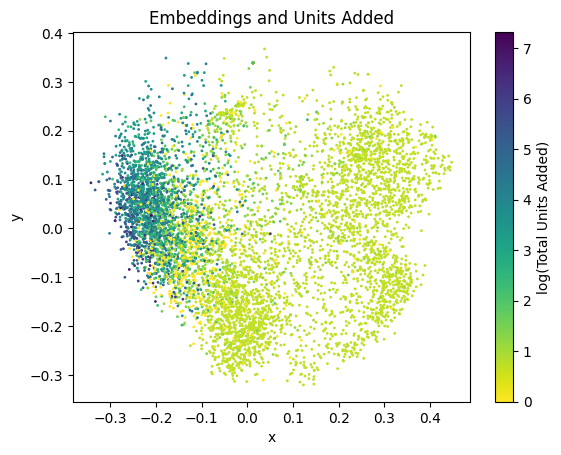

In [10]:
plt.scatter(x=X[:,0], y=X[:,1], c=np.log(1+df['Total Adding']), s=1, cmap='viridis_r')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(label='log(Total Units Added)')
plt.title('Embeddings and Units Added')
plt.show()

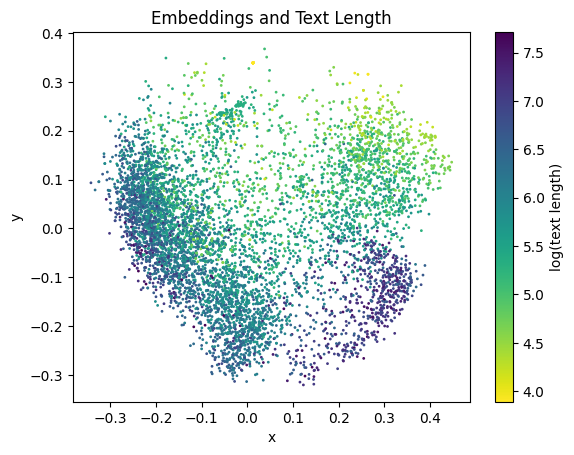

In [11]:
plt.scatter(x=X[:,0], y=X[:,1], c=np.log(df['text'].str.len()), s=1, cmap='viridis_r')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(label='log(text length)')
plt.title('Embeddings and Text Length')
plt.show()

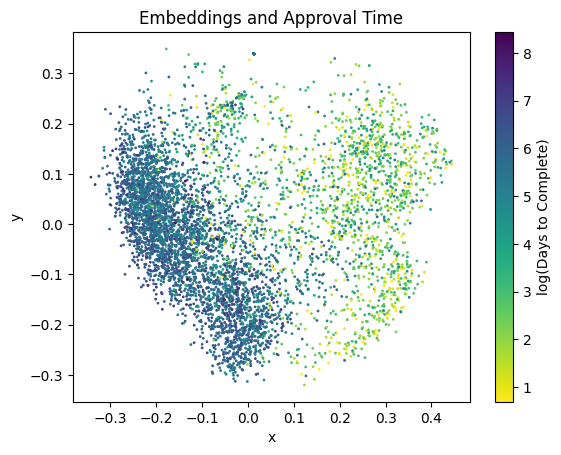

In [12]:
df['Days to Complete'] = (df['Completion Date'] - df['Filed Date'])/pd.to_timedelta(1,unit='D')
idx = df['Days to Complete']>0
plt.scatter(x=X[idx,0], y=X[idx,1], c=np.log(1+df.loc[idx,'Days to Complete']), s=1, cmap='viridis_r')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(label='log(Days to Complete)')
plt.title('Embeddings and Approval Time')
plt.show()

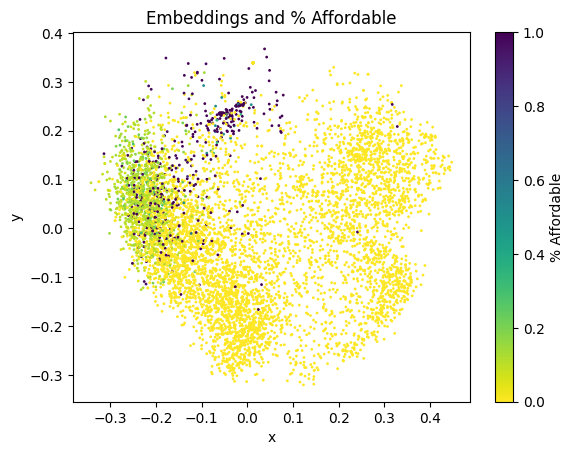

In [13]:
plt.scatter(x=X[:,0], y=X[:,1], c=df['% Affordable Adding'], s=1, cmap='viridis_r')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(label='% Affordable')
plt.title('Embeddings and % Affordable')
plt.show()

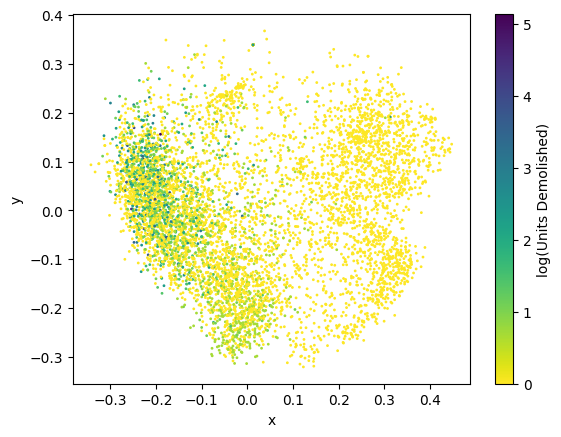

In [14]:
plt.scatter(x=X[:,0], y=X[:,1], c=np.log(1+df['Total Demo']), s=1, cmap='viridis_r')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(label='log(Units Demolished)')
plt.show()

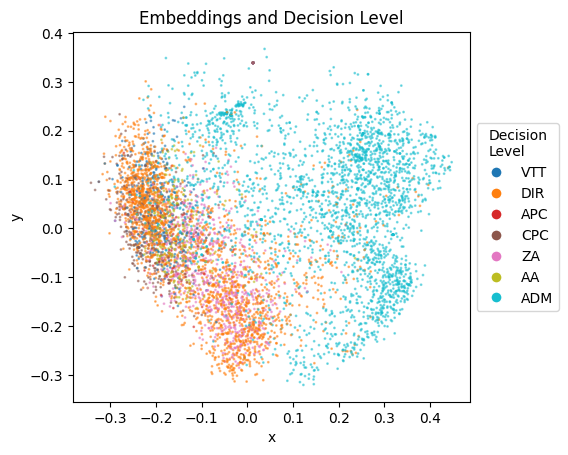

In [15]:
idx = df['case_pfx']!=''
cat_codes, cat_labels = pd.factorize(df.loc[idx,'case_pfx'])
cmap = plt.get_cmap('tab10', len(cat_labels))
colors = cmap(cat_codes)
sc = plt.scatter(x=X[idx,0], y=X[idx,1], c=colors, s=1, alpha=0.5)
cbar = plt.colorbar(sc)
cbar.ax.set_visible(False)
legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markersize=8, 
                              markerfacecolor=cmap(i), label=label)
                  for i, label in enumerate(cat_labels)]
plt.legend(handles=legend_patches, title="Decision\nLevel", loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('x')
plt.ylabel('y')
plt.title('Embeddings and Decision Level')
plt.show()

In [16]:
# Set up cross validation workflow for approval time prediction
N_FOLDS = 5
y = df['Days to Complete']
rmse_scorer = make_scorer(lambda y_true, y_pred: root_mean_squared_error(y_true, y_pred))

def get_cross_val_rmse(model, df, y):
    kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, df, y, scoring=rmse_scorer, cv=kf)
    return np.mean(cv_scores)


In [17]:
# Prepare Models based on number of PCA components

base_column_transformer_steps = [
    ('base_physical', StandardScaler(), [
        'Affordable Adding','Market Adding','Affordable Demo','Market Demo',
        'Guest Adding','Guest Demo','NonRes Adding','NonRes Demo'
    ]),
    ('base_categorical', OneHotEncoder(), ['Council District'])
]
pfx_column_transformer_steps = [
    ('pfx', OneHotEncoder(), ['case_pfx'])
]

df['const'] = 1

results_df = []
for base in [True, False]:
    for pfx in [True, False]:
        for n_components in range(K+1):
            print(f"base:{base}, pfx:{pfx}, n_components:{n_components}... ", end='')
            row = {'base':base, 'pfx':pfx, 'pca':n_components}
            column_transformer_steps = []
            if base:
                column_transformer_steps += base_column_transformer_steps
            if pfx:
                column_transformer_steps += pfx_column_transformer_steps
            if n_components>0:
                column_transformer_steps += [('pca','passthrough',[f"pca{j}" for j in range(n_components)])]
            if len(column_transformer_steps)==0:
                column_transformer_steps = [('const','passthrough',['const'])]
            column_transformer = ColumnTransformer(column_transformer_steps)
            model = Pipeline([
                ('column_transformer', column_transformer),
                ('regressor', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42))
            ])
            rmse = get_cross_val_rmse(model, df, y)
            row['rmse'] = rmse
            results_df.append(row)

results_df = pd.DataFrame.from_dict(results_df)

base:True, pfx:True, n_components:0... base:True, pfx:True, n_components:1... base:True, pfx:True, n_components:2... base:True, pfx:True, n_components:3... base:True, pfx:True, n_components:4... base:True, pfx:True, n_components:5... base:True, pfx:True, n_components:6... base:True, pfx:True, n_components:7... base:True, pfx:True, n_components:8... base:True, pfx:True, n_components:9... base:True, pfx:True, n_components:10... base:True, pfx:False, n_components:0... base:True, pfx:False, n_components:1... base:True, pfx:False, n_components:2... base:True, pfx:False, n_components:3... base:True, pfx:False, n_components:4... base:True, pfx:False, n_components:5... base:True, pfx:False, n_components:6... base:True, pfx:False, n_components:7... base:True, pfx:False, n_components:8... base:True, pfx:False, n_components:9... base:True, pfx:False, n_components:10... base:False, pfx:True, n_components:0... base:False, pfx:True, n_components:1... base:False, pfx:True, n_components:2... base:Fals

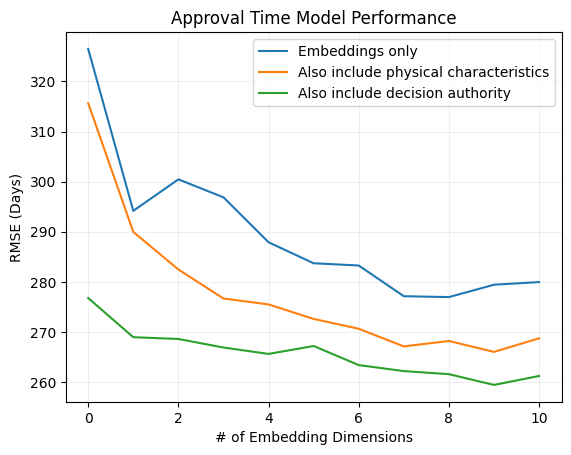

In [18]:
# Assess approval time model performance

idx = (results_df['base']==False) & (results_df['pfx']==False)
plt.plot(results_df.loc[idx, 'pca'], results_df.loc[idx, 'rmse'], label='Embeddings only')
idx = (results_df['base']==True) & (results_df['pfx']==False)
plt.plot(results_df.loc[idx, 'pca'], results_df.loc[idx, 'rmse'], label='Also include physical characteristics')
idx = (results_df['base']==True) & (results_df['pfx']==True)
plt.plot(results_df.loc[idx, 'pca'], results_df.loc[idx, 'rmse'], label='Also include decision authority')
plt.grid(alpha=0.2)
plt.xlabel('# of Embedding Dimensions')
plt.ylabel('RMSE (Days)')
plt.title('Approval Time Model Performance')
plt.legend()
plt.show()

In [19]:
# Set up cross validation workflow for decision authority prediction
N_FOLDS = 5
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['case_pfx'])
accuracy_scorer = make_scorer(lambda y_true, y_pred: accuracy_score(y_true, y_pred))

def get_cross_val_rmse(model, df, y):
    kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, df, y, scoring=accuracy_scorer, cv=kf)
    return np.mean(cv_scores)


In [20]:
# Prepare Models based on number of PCA components

base_column_transformer_steps = [
    ('base_physical', StandardScaler(), [
        'Affordable Adding','Market Adding','Affordable Demo','Market Demo',
        'Guest Adding','Guest Demo','NonRes Adding','NonRes Demo'
    ]),
    ('base_categorical', OneHotEncoder(), ['Council District'])
]
pfx_column_transformer_steps = [
    ('pfx', OneHotEncoder(), ['case_pfx'])
]

df['const'] = 1

results_df = []
for base in [True, False]:
    for n_components in range(K+1):
        print(f"base:{base}, n_components:{n_components}... ", end='')
        row = {'base':base, 'pca':n_components}
        column_transformer_steps = []
        if base:
            column_transformer_steps += base_column_transformer_steps
        if n_components>0:
            column_transformer_steps += [('pca','passthrough',[f"pca{j}" for j in range(n_components)])]
        if len(column_transformer_steps)==0:
            column_transformer_steps = [('const','passthrough',['const'])]
        column_transformer = ColumnTransformer(column_transformer_steps)
        model = Pipeline([
            ('column_transformer', column_transformer),
            ('regressor', xgb.XGBClassifier(eval_metric='logloss', n_estimators=100, random_state=42))
        ])
        accuracy = get_cross_val_rmse(model, df, y)
        row['accuracy'] = accuracy
        results_df.append(row)

results_df = pd.DataFrame.from_dict(results_df)

base:True, n_components:0... base:True, n_components:1... base:True, n_components:2... base:True, n_components:3... base:True, n_components:4... base:True, n_components:5... base:True, n_components:6... base:True, n_components:7... base:True, n_components:8... base:True, n_components:9... base:True, n_components:10... base:False, n_components:0... base:False, n_components:1... base:False, n_components:2... base:False, n_components:3... base:False, n_components:4... base:False, n_components:5... base:False, n_components:6... base:False, n_components:7... base:False, n_components:8... base:False, n_components:9... base:False, n_components:10... 

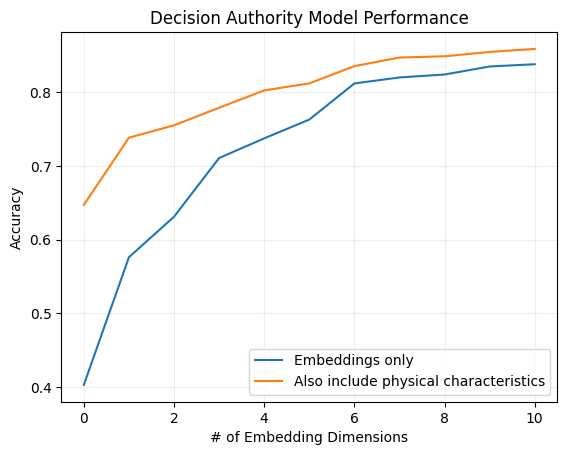

In [21]:
# Assess authority level predictor performance

idx = (results_df['base']==False)
plt.plot(results_df.loc[idx, 'pca'], results_df.loc[idx, 'accuracy'], label='Embeddings only')
idx = (results_df['base']==True)
plt.plot(results_df.loc[idx, 'pca'], results_df.loc[idx, 'accuracy'], label='Also include physical characteristics')
plt.grid(alpha=0.2)
plt.xlabel('# of Embedding Dimensions')
plt.ylabel('Accuracy')
plt.title('Decision Authority Model Performance')
plt.legend()
plt.show()